In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from subprocess import check_output

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data_path = 'D:/dataset/kaggle_Iceberg/'
train_path = data_path + "train.json"
test_path  = data_path + "test.json"
train_json = pd.read_json(train_path)
test_json = pd.read_json(test_path)
print (len(train_json))

1604


In [3]:
print("Train Records")
train_json.head()

Train Records


,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [4]:
print("Test Records")
test_json.head()

Test Records


,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.0589694977, -26.0589694977, -26.058969497...","[-25.7542076111, -25.7542076111, -25.754207611...",4023181e,32.615072
2,"[-14.1410999298, -15.0642414093, -17.375520706...","[-14.745639801, -14.5904102325, -14.3626976013...",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.3745937347, -26.0271816254, -28.121963501...","[-25.7223434448, -27.0115776062, -23.149162292...",4371c8c3,43.918874


In [5]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.data import vision

def transform_train(data, label):
    im = image.imresize(data.astype('float32') / 255, 75, 75)
    auglist = image.CreateAugmenter(data_shape=(3, 75, 75), resize=0,
                        rand_crop=True, rand_resize=False, rand_mirror=False,
                        mean=None, std=None,
                        brightness=0, contrast=0,
                        saturation=0, hue=0,
                        pca_noise=0, rand_gray=0, inter_method=2)
    for aug in auglist:
        im = aug(im)
    # 将数据格式从"高*宽*通道"改为"通道*高*宽"。
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))

def transform_test(data, label):
    im = image.imresize(data.astype('float32') / 255, 75, 755)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))

In [19]:
def data_norm(data):
    images = []
    for i,row in data.iterrows():
        band_1 = np.reshape(np.array(row["band_1"]).astype(np.float32),(75,75))
        band_2 = np.reshape(np.array(row["band_2"]).astype(np.float32),(75,75))
        band_3 = band_1+band_2

        band_1_norm = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        band_2_norm = (band_2 - band_2. mean()) / (band_2.max() - band_2.min())
        band_3_norm = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())
        images.append(np.stack((band_1_norm,band_2_norm,band_3_norm)))
    return np.array(images)

X_train_total = data_norm(train_json)
y_train_total = np.array(train_json['is_iceberg'])
X_angle_train_total = np.array(train_json.inc_angle)

X_test = data_norm(test_json)
X_angle_test = np.array(test_json.inc_angle)


In [20]:
# #Fix and Preprocess Data
# x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train_json["band_1"]])
# x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train_json["band_2"]])

# X_train_total = np.concatenate([x_band1[:, :, :, np.newaxis]
#                           , x_band2[:, :, :, np.newaxis]
#                          , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)
# X_angle_train_total = np.array(train_json.inc_angle)
# y_train_total = np.array(train_json["is_iceberg"],dtype='float')
# X_train_total = X_train_total.transpose((0,3,1,2))


# # Test data
# x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test_json["band_1"]])
# x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test_json["band_2"]])
# X_test = np.concatenate([x_band1[:, :, :, np.newaxis]
#                           , x_band2[:, :, :, np.newaxis]
#                          , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)
# X_angle_test = np.array(test_json.inc_angle)
# X_test = X_test.transpose((0,3,1,2))


X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(X_train_total
                    , X_angle_train_total, y_train_total, random_state=123, test_size=0.1)

    

y_test = np.zeros((X_test.shape[0],), dtype=np.int)

train_ds = gluon.data.ArrayDataset(X_train, y_train)
valid_ds = gluon.data.ArrayDataset(X_valid, y_valid)
train_valid_ds = gluon.data.ArrayDataset(X_train_total,y_train_total)
test_ds = gluon.data.ArrayDataset(X_test,y_test)

In [21]:
print X_train.shape

(1443L, 3L, 75L, 75L)


In [22]:
batch_size = 128
loader = gluon.data.DataLoader
train_data = loader(train_ds, batch_size, shuffle=True, last_batch='keep')
valid_data = loader(valid_ds, batch_size, shuffle=True, last_batch='keep')
train_valid_data= loader(train_valid_ds, batch_size, shuffle=True, last_batch='keep')
test_data = loader(test_ds,batch_size,shuffle = True,last_batch='keep')
# 交叉熵损失函数。
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [23]:
# Create model

from mxnet.gluon import nn
from mxnet import nd


def get_loss(data, net, ctx):
    loss = 0.0
    for feas, label in data:
        label = label.as_in_context(ctx)
        output = net(feas.as_in_context(ctx))
        cross_entropy = softmax_cross_entropy(output, label)
        loss += nd.mean(cross_entropy).asscalar()
    return loss / len(data)

class Residual(nn.HybridBlock):
    def __init__(self, channels, same_shape=True, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.same_shape = same_shape
        with self.name_scope():
            strides = 1 if same_shape else 2
            self.conv1 = nn.Conv2D(channels, kernel_size=3, padding=1,
                                  strides=strides)
            self.bn1 = nn.BatchNorm()
            self.conv2 = nn.Conv2D(channels, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm()
            if not same_shape:
                self.conv3 = nn.Conv2D(channels, kernel_size=1,
                                      strides=strides)

    def hybrid_forward(self, F, x):
        out = F.sigmoid(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if not self.same_shape:
            x = self.conv3(x)
        return F.sigmoid(out + x)


class ResNet(nn.HybridBlock):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(ResNet, self).__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope():
            net = self.net = nn.HybridSequential()
            # 模块1
            net.add(nn.Conv2D(channels=32, kernel_size=3, strides=1, padding=1))
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='sigmoid'))
            # 模块2
            for _ in range(3):
                net.add(Residual(channels=32))
            # 模块3
            net.add(Residual(channels=64, same_shape=False))
            for _ in range(2):
                net.add(Residual(channels=64))
            # 模块4
            net.add(Residual(channels=128, same_shape=False))
            for _ in range(2):
                net.add(Residual(channels=128))
            # 模块5
            net.add(nn.AvgPool2D(pool_size=8))
            net.add(nn.Flatten())
            net.add(nn.Dense(num_classes))

    def hybrid_forward(self, F, x):
        out = x
        for i, b in enumerate(self.net):
            out = b(out)
            if self.verbose:
                print('Block %d output: %s'%(i+1, out.shape))
        return out


def get_net(ctx):
    num_outputs = 2
    net = ResNet(num_outputs)
    net.initialize(ctx=ctx, init=init.Xavier())
    return net

In [24]:
import datetime
import sys
sys.path.append('..')
import utils
from matplotlib import pyplot as plt

def train(net, train_data, valid_data, num_epochs, lr, wd, ctx, lr_period,
          lr_decay):
    trainer = gluon.Trainer(
        net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9,
                                      'wd': wd})
    prev_time = datetime.datetime.now()
    plt_train_loss = []
    plt_valid_loss = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        if epoch < 81 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        if epoch > 81 and epoch % 10 == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.4)
        for data, label in train_data:
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data.as_in_context(ctx))
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(batch_size)
            train_loss += nd.mean(loss).asscalar()
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = get_loss(valid_data, net, ctx)
            epoch_str = ("Epoch %d. Train loss: %f, Valid loss %f, "
                         % (epoch, train_loss / len(train_data), valid_loss))
            plt_train_loss.append(train_loss / len(train_data))
            plt_valid_loss.append(valid_loss)
        else:
            epoch_str = ("Epoch %d. Train loss: %f, "
                         % (epoch, train_loss / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str + ', lr ' + str(trainer.learning_rate))

    # plot 
    if valid_data is not None:
        plt.plot(plt_train_loss)
        plt.plot(plt_valid_loss)
        plt.legend(['train_loss','test_loss'])
        plt.savefig("Loss22.png")


Epoch 0. Train loss: 0.692149, Valid loss 0.697753, Time 00:00:06, lr 0.001
Epoch 1. Train loss: 0.687728, Valid loss 0.699125, Time 00:00:06, lr 0.001
Epoch 2. Train loss: 0.683959, Valid loss 0.716411, Time 00:00:06, lr 0.001
Epoch 3. Train loss: 0.681885, Valid loss 0.708590, Time 00:00:06, lr 0.001
Epoch 4. Train loss: 0.677403, Valid loss 0.684905, Time 00:00:06, lr 0.001
Epoch 5. Train loss: 0.670429, Valid loss 0.716177, Time 00:00:06, lr 0.001
Epoch 6. Train loss: 0.662977, Valid loss 0.689975, Time 00:00:06, lr 0.001
Epoch 7. Train loss: 0.650112, Valid loss 0.731078, Time 00:00:06, lr 0.001
Epoch 8. Train loss: 0.634836, Valid loss 0.767942, Time 00:00:06, lr 0.001
Epoch 9. Train loss: 0.617269, Valid loss 0.870027, Time 00:00:06, lr 0.001
Epoch 10. Train loss: 0.588467, Valid loss 1.143741, Time 00:00:06, lr 0.001
Epoch 11. Train loss: 0.554011, Valid loss 1.696049, Time 00:00:06, lr 0.001
Epoch 12. Train loss: 0.524092, Valid loss 1.573412, Time 00:00:06, lr 0.001
Epoch 13.

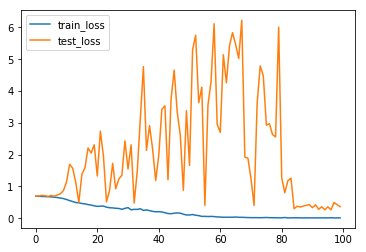

In [26]:
ctx = utils.try_gpu()
num_epochs = 100
learning_rate = 0.01
weight_decay = 5e-4
lr_period = 80
lr_decay = 0.1

net = get_net(ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate,weight_decay, ctx, lr_period, lr_decay)

In [27]:
import numpy as np

net = get_net(ctx)
net.hybridize()
train(net, train_valid_data, None, num_epochs, learning_rate, weight_decay,
      ctx, lr_period, lr_decay)

Epoch 0. Train loss: 0.962804, Time 00:00:11, lr 0.001
Epoch 1. Train loss: 0.736389, Time 00:00:07, lr 0.001
Epoch 2. Train loss: 0.682343, Time 00:00:07, lr 0.001
Epoch 3. Train loss: 0.668156, Time 00:00:07, lr 0.001
Epoch 4. Train loss: 0.657714, Time 00:00:07, lr 0.001
Epoch 5. Train loss: 0.645961, Time 00:00:07, lr 0.001
Epoch 6. Train loss: 0.627884, Time 00:00:07, lr 0.001
Epoch 7. Train loss: 0.608278, Time 00:00:07, lr 0.001
Epoch 8. Train loss: 0.587128, Time 00:00:07, lr 0.001
Epoch 9. Train loss: 0.564726, Time 00:00:07, lr 0.001
Epoch 10. Train loss: 0.536573, Time 00:00:07, lr 0.001
Epoch 11. Train loss: 0.507107, Time 00:00:07, lr 0.001
Epoch 12. Train loss: 0.486011, Time 00:00:07, lr 0.001
Epoch 13. Train loss: 0.460447, Time 00:00:07, lr 0.001
Epoch 14. Train loss: 0.449548, Time 00:00:07, lr 0.001
Epoch 15. Train loss: 0.420477, Time 00:00:07, lr 0.001
Epoch 16. Train loss: 0.414294, Time 00:00:07, lr 0.001
Epoch 17. Train loss: 0.398011, Time 00:00:07, lr 0.001
Ep

In [28]:
outputs = []
for data, label in test_data:
    output = nd.softmax(net(data.as_in_context(ctx)))
    outputs.extend(output.asnumpy())

In [29]:
test_pre = []

for num in outputs:
    test_pre.append(num[1])
print len(test_pre)

8424


In [30]:
submission = pd.DataFrame({'id': test_json["id"], 'is_iceberg': test_pre})

In [31]:
submission.to_csv("submission.csv", index=False)